<a href="https://colab.research.google.com/github/matzewolf/my-colab-notebooks/blob/master/fer_cnn/test_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build and train DNNs

First, some preparations for the notebook:  
- Necessary libraries are imported, especially TensorFlow 2.0 as Keras' backend and required submodules of Keras itself.
- **For transfer learning, it is important to import pre-trained models, so called Applications, in Keras.**
- Connect Colab notebook to Google Drive as a virtual filesystem, as the training data is stored there. This requires a new authentification for every fresh runtime.
- Define some paths: The base path in Google Drive `GDRIVE_PATH` contains the training data at the `DATA_PATH` and information to each model (model parameters, training history and accuracy/loss plots) at the `MODEL_PATH`.
- **Models sometimes cannot be saved because of a bug in Colab!**

In [19]:
# General imports
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Scikit-Learn imports
from sklearn.model_selection import train_test_split

# Import TensorFlow as Keras' backend
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)
assert tf.__version__ >= "2.0"

# Import Keras modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# IMPORTANT: Import pre-trained models for transfer learning!
from tensorflow.keras.applications import mobilenet_v2

# Connect to Google Drive (requires authentification every new session)
from google.colab import drive
drive.mount('/content/drive')

# Define paths
GDRIVE_PATH = "/content/drive/My Drive/Colab Notebooks/bsc_fer_cnn"
DATA_PATH   = os.path.join(GDRIVE_PATH, "data")
MODEL_PATH  = os.path.join(GDRIVE_PATH, "models")

Tensorflow version: 2.0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training evaluation: plot accuracy/loss and save

In [0]:
def train_eval(history, figure_path):

    fig = plt.figure(figsize=(8,12))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.gca().set_ylim(0, 1)
    plt.grid(True)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower left')

    plt.savefig(figure_path)
    plt.show()

## Global definitions

- Define shape of input data (training features). **CAUTION:** All pre-trained models require 3 channels (RGB) instead of just 1 (grayscale).
- Load training set: features `X` and labels `y`
- Convert training features from grayscale to RGB by just repeating the grayscale channel three times.
- Split into train and validation datasets.
- Define image data generators that preprocess the image data.
- Define the Early Stopping callback to avoid overfitting.

In [0]:
INPUT_SHAPE = (48, 48, 3)
NUM_CLASSES = 7

# Feature data - 1 channel (grayscale)
X = np.load(os.path.join(DATA_PATH, "fer2013_X.npy"))
# Feature data - 3 channels (RGB)
X_rgb = np.repeat(X, 3, axis=3)
# Labels
y = np.load(os.path.join(DATA_PATH, "fer2013_y.npy"))

# Split into training and validation data
X_train,     X_val,     y_train, y_val = train_test_split(X,     y, 
                                                          test_size=0.2)
X_train_rgb, X_val_rgb, y_train, y_val = train_test_split(X_rgb, y, 
                                                          test_size=0.2)

# Define constants: Sample and batch size
num_samples = np.size(X_train, 0)
num_val_samples = np.size(X_val, 0)
batch_size = 32

# Image data generators
train_datagen_wo_aug = ImageDataGenerator(rescale=1./255)
train_datagen_w_aug  = ImageDataGenerator(rescale=1./255, 
                                          rotation_range=30, 
                                          width_shift_range=0.2, 
                                          height_shift_range=0.2, 
                                          horizontal_flip = 'true')             
val_datagen          = ImageDataGenerator(rescale=1./255)

# Generator flows
train_gen_wo_aug     = train_datagen_wo_aug.flow(X_train, y_train, 
                                                 batch_size=batch_size, 
                                                 shuffle=False)
train_gen_w_aug      = train_datagen_w_aug.flow (X_train, y_train, 
                                                 batch_size=batch_size,
                                                 shuffle=False)
train_rgb_gen_wo_aug = train_datagen_wo_aug.flow(X_train_rgb, y_train, 
                                                 batch_size=batch_size, 
                                                 shuffle=False)
train_rgb_gen_w_aug  = train_datagen_w_aug.flow (X_train_rgb, y_train, 
                                                 batch_size=batch_size,
                                                 shuffle=False)
val_gen              = val_datagen.flow         (X_val, y_val, 
                                                 batch_size=batch_size,  
                                                 shuffle=False)
val_rgb_gen          = val_datagen.flow         (X_val_rgb, y_val, 
                                                 batch_size=batch_size,  
                                                 shuffle=False)

# Early stop callback
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

## Definition of training a model

**Issue**: Because of a bug in Colab, saving model files is sometimes not possible.

See also https://github.com/googlecolab/colabtools/issues/559

In [0]:
def train_model(model, name, augmentation=False, rgb=False, num_epochs=100):
        
    # Compile the model for multiclass classification
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Determine the generators to be used
    if   rgb is False:
        val_generator = val_gen
        if   augmentation is False:
            generator = train_gen_wo_aug
        elif augmentation is True:
            generator = train_gen_w_aug
    elif rgb is True:
        val_generator = val_rgb_gen
        if   augmentation is False:
            generator = train_rgb_gen_wo_aug
        elif augmentation is True:
            generator = train_rgb_gen_w_aug

    # Create directory to save model, history and plots
    name += time.strftime("_%Y-%m-%d_%H:%M:%S")
    save_dir = os.path.join(MODEL_PATH, name)
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Saving best model with checkpoint callback
    model_path = os.path.join(save_dir, name + ".h5")
    checkpoint = ModelCheckpoint(model_path, save_best_only=True)

    # Training the model
    history = model.fit_generator(generator, 
                                  validation_data=val_generator,
                                  steps_per_epoch=num_samples//batch_size,
                                  validation_steps=num_val_samples//batch_size,
                                  epochs=num_epochs,
                                  callbacks=[early_stop, checkpoint])

    # Saving history
    history_path = os.path.join(save_dir, name + ".pkl")
    history_df = pd.DataFrame(history.history) 
    history_df.to_pickle(history_path)

    # Saving plots
    figure_path = os.path.join(save_dir, name + ".png")
    train_eval(history, figure_path)

    return model, history

## Basic example: 2 conv + 2 dense

In [17]:
model = Sequential([
    
    Conv2D(256, (2, 2), input_shape=X.shape[1:], activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),
    
    Conv2D(256, (2, 2), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    Dense(64),
    Dense(7, activation="softmax")
    
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 256)       1280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 256)       262400    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                

Epoch 1/100
717/717 [==============================] - 34s 48ms/step - loss: 1.8121 - accuracy: 0.2514 - val_loss: 1.8134 - val_accuracy: 0.2514
Epoch 2/100
717/717 [==============================] - 33s 46ms/step - loss: 1.8108 - accuracy: 0.2512 - val_loss: 1.8141 - val_accuracy: 0.2514
Epoch 3/100
717/717 [==============================] - 34s 48ms/step - loss: 1.8109 - accuracy: 0.2511 - val_loss: 1.8124 - val_accuracy: 0.2514
Epoch 4/100
717/717 [==============================] - 33s 47ms/step - loss: 1.8101 - accuracy: 0.2514 - val_loss: 1.8120 - val_accuracy: 0.2514
Epoch 5/100
717/717 [==============================] - 33s 46ms/step - loss: 1.8099 - accuracy: 0.2511 - val_loss: 1.8125 - val_accuracy: 0.2514
Epoch 6/100
717/717 [==============================] - 33s 46ms/step - loss: 1.8095 - accuracy: 0.2518 - val_loss: 1.8123 - val_accuracy: 0.2509


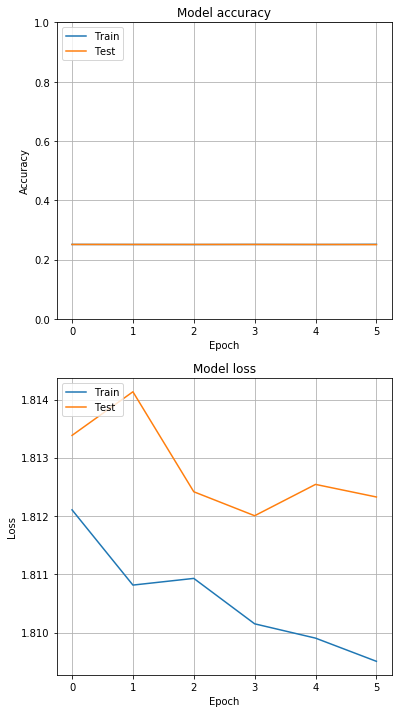

In [21]:
model, history = train_model(model, name="test")

## MobileNetV2 model without top layers for Transfer Learning

In [0]:
mnetv2 = mobilenet_v2.MobileNetV2(input_shape=INPUT_SHAPE, alpha=1.0, 
                                  include_top=False, weights='imagenet')

/tensorflow-2.0.0-rc2/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


## Prepare MobileNetV2 model

- Include a layer that converts to 1D
- Define it as a model
- Freeze all parameters (make it not trainable), so that it only serves as a feature extractor.

In [0]:
out = mnetv2.output
out = GlobalAveragePooling2D()(out)

mnetv2_model = Model(mnetv2.input, out)
mnetv2_model.trainable = True #False

for layer in mnetv2_model.layers:
    layer.trainable = True #False

mnetv2_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
model = Sequential([
    
    mnetv2_model,  # for feature extraction with transfer learning

    Dense(512, activation='relu', input_dim=mnetv2_model.output_shape[1]),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 3591      
Total params: 3,180,103
Trainable params: 3,145,991
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
model, history = train_model(model, name="transfer1", 
                             augmentation=True, rgb=True)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
717/717 [==============================] - 248s 346ms/step - loss: 1.6952 - accuracy: 0.3306 - val_loss: 2.1194 - val_accuracy: 0.2936
Epoch 2/100
717/717 [==============================] - 251s 350ms/step - loss: 1.5153 - accuracy: 0.4153 - val_loss: 2.9140 - val_accuracy: 0.2683
Epoch 3/100
717/717 [==============================] - 250s 349ms/step - loss: 1.4635 - accuracy: 0.4327 - val_loss: 2.5612 - val_accuracy: 0.3251
Epoch 4/100
717/717 [==============================] - 249s 347ms/step - loss: 1.3810 - accuracy: 0.4725 - val_loss: 3.2028 - val_accuracy: 0.1575
Epoch 5/100
717/717 [==============================] - 256s 356ms/step - loss: 1.4209 - accuracy: 0.4555 - val_loss: 1.9388 - val_accuracy: 0.1872
Epoch 6/100
717/717 [==============================] - 256s 356ms/step - loss: 1.4436 - accuracy: 0.4459 - val_loss: 2.2656 - val_accuracy: 0.1796
Epoch 7/100
717/717 [===

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bsc_fer_cnn/models/transfer/assets


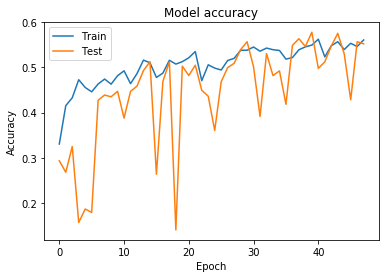

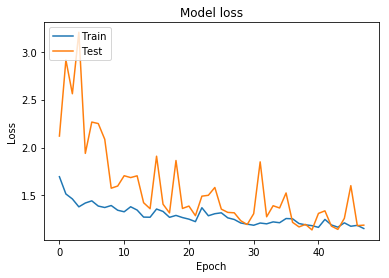

In [0]:
train_eval(history)

---
## Try #2: 3 dense

In [0]:
model = Sequential([
    
    Flatten(input_shape=X.shape[1:]),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(7, activation="softmax")
    
])

model.summary()

In [0]:
model, history = train_model(model, name="test2_3dense")

## Try #3: 5 conv layers without dropout

In [0]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:], activation="relu"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(100))

model.add(Dense(7, activation="softmax"))  # or sigmoid?

model.summary()

In [0]:
model, history = train_model(model, name="test3_5conv")

## Try #4: Like #3, but with dropout

In [0]:
model = Sequential()

model.add(Conv2D(256, (4, 4), input_shape=X.shape[1:], activation="relu"))
model.add(Conv2D(256, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (4, 4), activation="relu"))
model.add(Conv2D(256, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(100))
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))  # or sigmoid?

model.summary()

In [0]:
model, history = train_model(model, name="test4_5conv_dropout")